# Detection heatmaps for the Yolov5 model
This notebook shows how to generate detection heatmaps for the Yolov5 model.

© Steadforce GmbH 2020



#0. Get dependencies and the pretrained model

In [ ]:
%%capture
!pip install shap
!git clone https://github.com/ultralytics/yolov5
!wget https://github.com/ultralytics/yolov5/releases/download/v3.0/yolov5s.pt

In [ ]:
# Current yolov5 code is not compatible with torch==1.7 in colab.
# Modify the Hardswish forward() method not to use the 'inplace' attribute
!sed -i "s/return F.hardswish(input, self.inplace)/return F.hardswish(input)/" /usr/local/lib/python3.6/dist-packages/torch/nn/modules/activation.py 

sed: can't read /usr/local/lib/python3.6/dist-packages/torch/nn/modules/activation.py: No such file or directory


In [ ]:
%cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/content/yolov5


# 1. Import all modules

In [ ]:
import json
import random

import torch
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2

from utils.general import non_max_suppression, box_iou

device = torch.device('cuda:0')

# 2. Load and prepare the image with detected object

In [ ]:
img_size = 5*32

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
img_org = cv2.imread("data/images/MMZ_0006.tiff", cv2.IMREAD_COLOR)
#img_org = cv2.imread("data/images/false_positive.jpg", cv2.IMREAD_COLOR)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

old_img_size = img_org.shape[:2] # old size is in (height, width) format

ratio = float(img_size)/max(old_img_size)
new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])

img = cv2.resize(img_org, (new_size_x, new_size_y))

delta_w = img_size - new_size_x
delta_h = img_size - new_size_y
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
img = img.astype("float64")/255

img_gray = rgb2gray(img)    

plt.figure(figsize=(15, 15))
plt.imshow(img_org)
plt.show()

fig = plt.figure(figsize=(20, 40))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
%%capture
# https://pixabay.com/photos/kangaroo-eastern-grey-australian-4316459/ 
# save as data/images/false_positive.jpg

#https://cocodataset.org/#explore?id=76937 
!wget http://farm4.staticflickr.com/3559/3320369408_f2d3c9f9f6_z.jpg -O data/images/person.jpg


# 3. Load model and perform inference on the image

In [ ]:
model = torch.load("../yolov5/best.pt", map_location=device)['model'].float().eval()
_ = model.half() # use half precision float16 values

In [ ]:
confidence = 0.45
iou = 0.45

In [ ]:
torch_image = torch.from_numpy(np.ascontiguousarray(img.transpose(2, 0, 1))).to(device).unsqueeze(0).half()

prediction = model(torch_image)
print(prediction[0].shape, "# (1 image) x (1575 positions for predictions) x (4 coordinates, 1 object score, 80 class probabilities)")
output = non_max_suppression(prediction[0], conf_thres=confidence, iou_thres=iou)
print(output[0], "#[x1, y1, x2, y2, class prob.*obj. score, class_index]")

torch.Size([1, 1575, 20]) # (1 image) x (1575 positions for predictions) x (4 coordinates, 1 object score, 80 class probabilities)
tensor([[1.25000e-01, 3.12500e-01, 1.59750e+02, 1.60750e+02, 4.77783e-01, 1.00000e+01]], device='cuda:0') #[x1, y1, x2, y2, class prob.*obj. score, class_index]


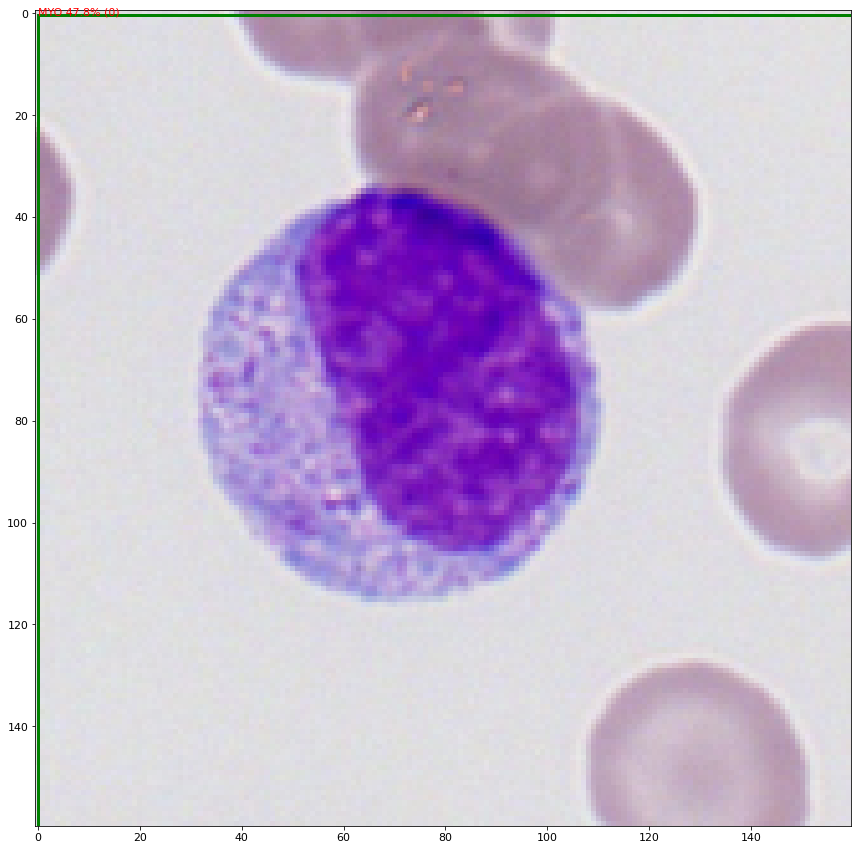

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(img)
for i, detection in enumerate(output[0].cpu().numpy()):
  label = f"{model.names[int(detection[5])]} {detection[4]:0.1%} ({i})"
  bbox = patches.Rectangle(detection[:2], detection[2]-detection[0], detection[3]-detection[1], linewidth=3, edgecolor='g', facecolor='none')
  plt.text(detection[0], detection[1], label, color="red")
  ax.add_patch(bbox)
plt.show()

# 4. Implement adapter functions as NN layers

In [ ]:
class CastNumpy(torch.nn.Module):
  def __init__(self):
    super(CastNumpy, self).__init__()
  
  def forward(self, image):
    """
    In the forward function we accept the inputs and cast them to a pytorch tensor
    """
    
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image).to(device)
    if image.ndimension() == 3:
      image = image.unsqueeze(0)
    image_half = image.half()
    
    return image_half

numpy2torch_converter = CastNumpy()

In [ ]:
numpy2torch_converter.forward(img.transpose(2, 0, 1))

tensor([[[[0.86670, 0.87451, 0.85889,  ..., 0.88232, 0.87842, 0.87842],
          [0.87451, 0.87061, 0.87451,  ..., 0.87061, 0.88232, 0.88232],
          [0.87842, 0.87842, 0.87061,  ..., 0.87842, 0.88232, 0.89404],
          ...,
          [0.89404, 0.88623, 0.89404,  ..., 0.88232, 0.87451, 0.87842],
          [0.86670, 0.87451, 0.87451,  ..., 0.89014, 0.88232, 0.87451],
          [0.86279, 0.86670, 0.87451,  ..., 0.87451, 0.87842, 0.88232]],

         [[0.86279, 0.86670, 0.85107,  ..., 0.87842, 0.88623, 0.87842],
          [0.87061, 0.86279, 0.86279,  ..., 0.87061, 0.88232, 0.87842],
          [0.87451, 0.87061, 0.85889,  ..., 0.87451, 0.87842, 0.89014],
          ...,
          [0.88232, 0.86670, 0.87451,  ..., 0.86279, 0.86279, 0.87061],
          [0.86670, 0.86670, 0.86279,  ..., 0.87061, 0.86279, 0.86279],
          [0.87451, 0.87061, 0.87061,  ..., 0.86670, 0.87061, 0.87451]],

         [[0.87842, 0.88623, 0.87061,  ..., 0.90186, 0.88232, 0.89014],
          [0.88232, 0.88232, 0

In [ ]:
class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        """
        constructor
        """
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        """
        In the forward function we accept the predictions and return the score for a selected target of the box
        """
        
        score_best_box = torch.zeros([x[0].shape[0]], device=device)

        for idx, img in enumerate(x[0]):
          img = img.unsqueeze(0)
        
          output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)
          if output and output[0] is not None:
            correct_class_predictions = output[0][...,5] == self.target[5]
            correctly_labeled_boxes = output[0][correct_class_predictions]
            
            if correctly_labeled_boxes.shape[0]:
              iou_with_target, _idx = box_iou(correctly_labeled_boxes[:,:4], self.target.unsqueeze(0)[:,:4]).max(1)
              index_best_box_in_correct_class = torch.argmax(iou_with_target)
              index_best_box_in_output = torch.where(output[0][...,5] == self.target[5])[0][index_best_box_in_correct_class]

              # score for the detection is the score from the prediction steps times intersection with expected position: (object score x class score) x iou_with_target

              # classification score
              #score_best_box[idx] = output[0][index_best_box_in_output][4]
              # position score
              #score_best_box[idx] = iou_with_target[index_best_box_in_correct_class]
              # both
              score_best_box[idx] = output[0][index_best_box_in_output][4]*iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

# look at the image output above and set the index of the object you want to analyze here
target_index = 0
target = output[0].cpu().numpy()[target_index]
scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)

In [ ]:
print(scoring.forward(prediction), "# score for target prediction")

[    0.47778] # score for target prediction


In [ ]:
class SuperPixler(torch.nn.Module):
  def __init__(self, image, super_pixel_width):
    super(SuperPixler, self).__init__()
    
    self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
    self.mean_color = self.image.mean()
    self.image = np.expand_dims(self.image, axis=0)
    self.image_width = image.shape[1]
    self.super_pixel_width = super_pixel_width

  
  def forward(self, x):
    """
    In the forward step we accept the super pixel masks and transform them to a batch of images
    """

    pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

    for i, super_pixel in enumerate(x.T):
      images_to_pixelate = [bool(p) for p in super_pixel]
      x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
      y = i*self.super_pixel_width%self.image_width
      pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color
    
    return pixeled_image

super_pixel_width = 16
assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"   
n_super_pixel = int((img.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width)

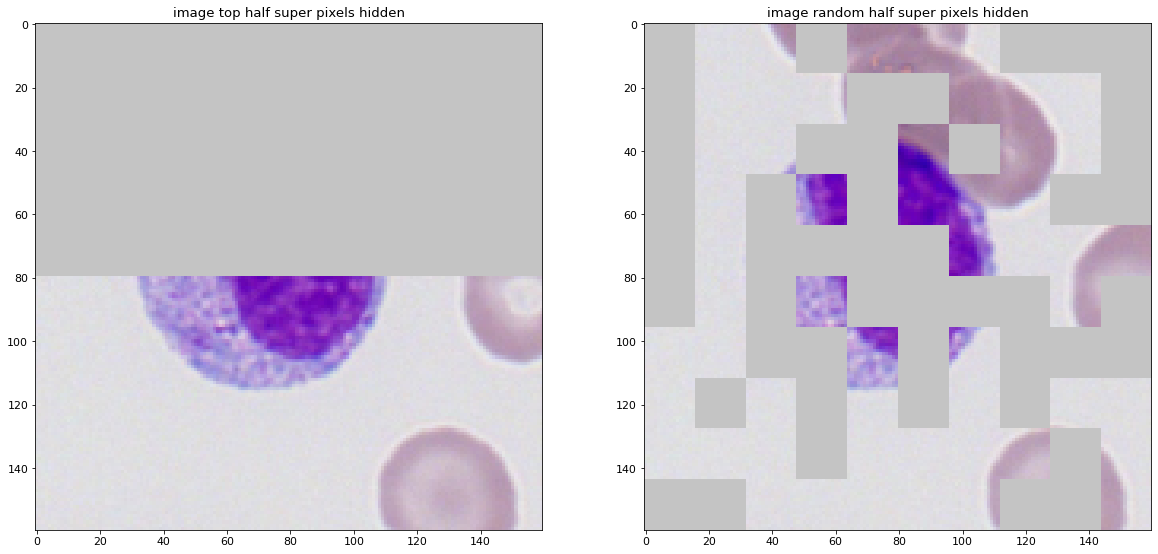

In [ ]:
img_s = super_pixler.forward(np.array([[1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], 
                                       [random.randint(0,1) for _ in range(n_super_pixel)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
plt.show()

In [ ]:
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

In [ ]:
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)]]))
print(score, "# score for whole image hidden")
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)], # empty image
                                    [0 for _ in range(n_super_pixel)], # full image
                                    [1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], # top half blacked out
                                    [random.randint(0,1) for _ in range(n_super_pixel)]])) # randomly half the patches blacked out
print(score, "# scores for all, none, top half, random half of the image hidden")

[          0] # score for whole image hidden
[          0     0.47778           0           0] # scores for all, none, top half, random half of the image hidden


# 5. Calculate SHAP values for patches of the image

In [ ]:
# use Kernel SHAP to explain the detection

background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

# Very large values for nsamples cause OOM errors depending on image and super pixel parameter. We combine batches of SHAP values to distribute the load. 
collected_shap_values = np.zeros_like(background_super_pixel)
b = 25
for i in range(b):
  print(f"{i/b:0.2%}")

  shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=1000)

  # take shap value with highest abs. value for each pixel from each batch
  stacked_values = np.vstack([shap_values, collected_shap_values])
  index_max_values = np.argmax(np.abs(stacked_values), axis=0)
  collected_shap_values = stacked_values[index_max_values, range(shap_values.shape[1])]
print((collected_shap_values!=0).sum(), "non-zero shap values found")

# plot the found SHAP values. Expected value does not match due to merging of batches
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, collected_shap_values)

0.00%



4.00%



8.00%



12.00%



16.00%



20.00%



24.00%



28.00%



32.00%



36.00%



40.00%



44.00%



48.00%



52.00%



56.00%



60.00%



64.00%



68.00%



72.00%



76.00%



80.00%



84.00%



88.00%



92.00%



96.00%



100 non-zero shap values found


In [ ]:
# match super pixels back to image pixels
shap_to_pixel = collected_shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
shap_to_pixel = shap_to_pixel/(np.max(np.abs(collected_shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map

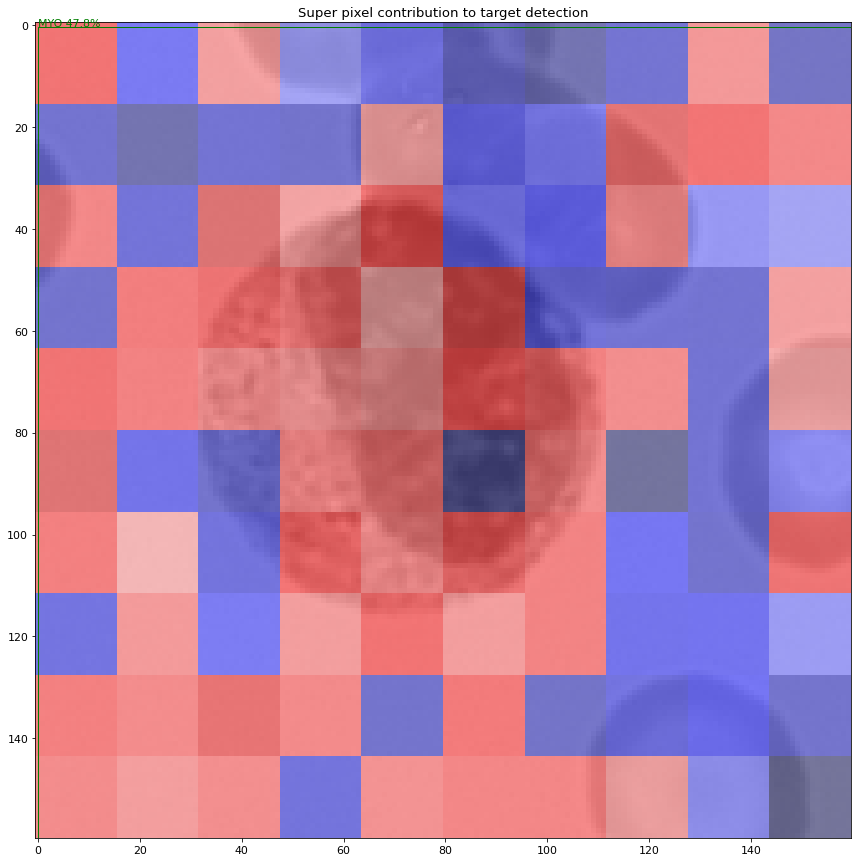

In [ ]:
# plot image and shap values for super pixels on top
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Super pixel contribution to target detection")
ax.imshow(img_gray, alpha=0.7, cmap='gray', vmin=0, vmax=1)
ax.imshow(shap_to_pixel, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.5)

# Add bounding box of target
label = f"{model.names[int(target[5])]} {target[4]:0.1%}"
plt.text(target[0], target[1], label, color="green")
bbox = patches.Rectangle(target[:2], target[2]-target[0], target[3]-target[1], linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(bbox)
plt.show()

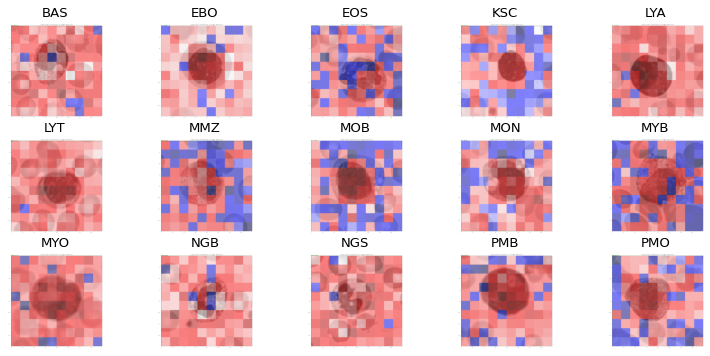

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

bas  = Image.open("data/images/BAS.png") 
ebo  = Image.open("data/images/EBO.png") 
eos  = Image.open("data/images/EOS.png") 
ksc  = Image.open("data/images/KSC.png") 
lya  = Image.open("data/images/LYA.png") 
lyt  = Image.open("data/images/LYT.png") 
mmz  = Image.open("data/images/MMZ.png") 
mob  = Image.open("data/images/MOB.png") 
mon  = Image.open("data/images/MON.png") 
myb  = Image.open("data/images/MYB.png") 
myo  = Image.open("data/images/MYO.png") 
ngb  = Image.open("data/images/NGB.png") 
ngs  = Image.open("data/images/NGS.png") 
pmb  = Image.open("data/images/PMB.png") 
pmo  = Image.open("data/images/PMO.png") 

plt.figure(figsize=(13, 6))

plt.subplot(3, 5, 1)
plt.imshow(bas)
plt.title('BAS')
plt.axis("off")

plt.subplot(3, 5, 2)
plt.imshow(ebo)
plt.title('EBO')
plt.axis("off")

plt.subplot(3, 5, 3)
plt.imshow(eos)
plt.title('EOS')
plt.axis("off")

plt.subplot(3, 5, 4)
plt.imshow(ksc)
plt.title('KSC')
plt.axis("off")

plt.subplot(3, 5, 5)
plt.imshow(lya)
plt.title('LYA')
plt.axis("off")

plt.subplot(3, 5, 6)
plt.imshow(lyt)
plt.title('LYT')
plt.axis("off")

plt.subplot(3, 5, 7)
plt.imshow(mmz)
plt.title('MMZ')
plt.axis("off")

plt.subplot(3, 5, 8)
plt.imshow(mob)
plt.title('MOB')
plt.axis("off")

plt.subplot(3, 5, 9)
plt.imshow(mon)
plt.title('MON')
plt.axis("off")

plt.subplot(3, 5, 10)
plt.imshow(myb)
plt.title('MYB')
plt.axis("off")

plt.subplot(3, 5, 11)
plt.imshow(myo)
plt.title('MYO')
plt.axis("off")

plt.subplot(3, 5, 12)
plt.imshow(ngb)
plt.title('NGB')
plt.axis("off")

plt.subplot(3, 5, 13)
plt.imshow(ngs)
plt.title('NGS')
plt.axis("off")

plt.subplot(3, 5, 14)
plt.imshow(pmb)
plt.title('PMB')
plt.axis("off")

plt.subplot(3, 5, 15)
plt.imshow(pmo)
plt.title('PMO')
plt.axis("off")

plt.show()
